# Введение в нейронные сети

## Урок 3. TensorFlow

1. Попробуйте улучшить работу нейронной сети (разобранную на уроке).
2. Поработайте с документацией TensorFlow. Попробуйте найти полезные команды TensorFlow, неразобранные на уроке
3. \* Попробуйте обучить нейронную сеть на TensorFlow 2 на датасете imdb_reviews.

### На примере массива imdb

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

from keras.datasets import imdb
from sklearn.metrics import confusion_matrix as conf_m
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns

%matplotlib inline

Обучим нейронную сеть с помощью TensorFlow на примере [IMDB dataset](https://ai.stanford.edu/~amaas/data/sentiment/)

Это набор данных из 25 000 отзывов о фильмах из IMDB, помеченных по настроению (положительное/отрицательное). Обзоры были предварительно обработаны, и каждый обзор закодирован как список индексов слов (целых чисел). Для удобства слова индексируются по общей частоте в наборе данных, так что, например, целое число «3» кодирует 3-е наиболее часто встречающееся слово в данных. Это позволяет выполнять быстрые операции фильтрации, такие как: «учитывать только 10 000 самых распространенных слов, но исключать 20 самых распространенных слов»

In [2]:
# Выберем параметры сети
batch_size = 500
epochs = 4

tf.random.set_seed(1)
initializer = tf.keras.initializers.RandomNormal(seed=1)

In [3]:
# Выберем 10000 наиболее часто встречающихся в отзывах слов
num_words = 10000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
data = pd.concat([pd.Series(x_train), pd.Series(x_test)], ignore_index=True)

In [4]:
# Получим индексы для декодирования слов
index = imdb.get_word_index()

# Проверим, как происходит декодирование. Если слово не известно (не попало в num_words), то оно будет обозначено "#"
reverse_index = dict([(value, key) for (key, value) in index.items()]) 
decoded = " ".join( [reverse_index.get(i - 3, "#") for i in data[0]] )
print(decoded)

# this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert # is an amazing actor and now the same being director # father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for # and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also # to the two little boy's that played the # of norman and paul they were just brilliant children are often left out of the # list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

In [5]:
# Создадим функцию для кодирования каждого слова в вектор
def vectorize(sequences, dimension = num_words):
    results = pd.DataFrame(0, index=range(len(sequences)), columns=range(1, dimension + 1))
    for i, sequence in enumerate(sequences):
        results.iloc[i, sequence] = 1
    return results.astype('int8')

# Обработаем данные
data = vectorize(data)
targets = pd.Series(list(y_train) + list(y_test))
targets = targets.astype("int8")

X_test = data[:num_words]
y_test = targets[:num_words]
X_train = data[num_words:]
y_train = targets[num_words:]

logs = pd.DataFrame(columns=['n_layers', 'n_nums', 'act_func', 'opt', 'train_acc', 'test_acc'])
parameters = [X_test, y_test, X_train, y_train, batch_size, epochs, num_words, initializer]

In [6]:
X_train

,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
10000,0,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
10001,0,1,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
10002,0,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
10003,0,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
10004,0,1,1,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
49996,0,1,1,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
49997,0,1,1,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
49998,0,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000, 10000)
(10000, 10000)
(40000,)
(10000,)


Будем проверять следующие значения:<br>
n_layers: 3, 5 и 10 <br>
n_nums: 8, 32 и 128 <br>
act_func: ReLU, sigmoid и tanh <br>
opt: RMSProp и Adam<br>
У нас задача бинарной классификации. Поэтому, на выходном слое возьмём функцию активации sigmoid. В качестве основной метрики возьмём accuracy

In [8]:
# Создадим функцию для обучения моделей
def model_by_parameters(n_layers, parameters):
    fig = plt.figure(figsize=(30,20))
    plt.subplots_adjust(wspace=0.1, hspace=0.5)
    logs = pd.DataFrame(columns=['n_layers', 'n_nums', 'act_func', 'opt', 'train_acc', 'test_acc'])
    k = 0
    
    for n in [8, 32, 128]:
        for f in ['relu', 'sigmoid', 'tanh']:
            k += 1
            for o in ['RMSprop', 'Adam']:
                print(f'\nПараметры текущей нейронной сети: количество слоёв - {n_layers}, нейронов - {n}, функция активации - {f}, оптимизатор - {o}')
                inputs = Input(shape=(num_words,))
                x = Flatten()(inputs)
                for i in range(n_layers-2):
                    x = Dense(n, activation=f, kernel_initializer=initializer)(x)
                outputs = Dense(1, activation='sigmoid', kernel_initializer=initializer)(x)
                model = Model(inputs, outputs)

                model.compile(optimizer=o,
                            loss = "binary_crossentropy",
                             metrics = ["accuracy"])

                # model.summary()

                history = model.fit(X_train, y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_test, y_test), 
                            verbose=0)

                train_loss, train_m = model.evaluate(X_train, y_train, verbose=2)
                test_loss, test_m = model.evaluate(X_test, y_test, verbose=2)
                
                logs.loc[len(logs.index)] = [n_layers, n, f, o, train_m, test_m]

                ax = fig.add_subplot(6, 2, k)
                ax.plot(history.history['val_accuracy'], label=f'val {o} {round(test_m,2)}', scaley=False)
                ax.plot(history.history['accuracy'], label=f'train {o} {round(train_m,2)}', scaley=False)
                ax.legend()
                ax.set_xlabel('epoch')
                ax.set_yticks(np.arange(0.4, 1, 0.1))
                ax.set_ylabel('accuracy')
                ax.set_ylim([0.4, 1])
                ax.set(title = f'Точность сети от эпох при {n} нейронах и функции активации {f}')
                
    plt.show()
    return logs

### Модель с тремя слоями


Параметры текущей нейронной сети: количество слоёв - 3, нейронов - 8, функция активации - relu, оптимизатор - RMSprop
1250/1250 - 2s - loss: 0.2486 - accuracy: 0.9061 - 2s/epoch - 2ms/step
313/313 - 1s - loss: 0.2832 - accuracy: 0.8867 - 505ms/epoch - 2ms/step

Параметры текущей нейронной сети: количество слоёв - 3, нейронов - 8, функция активации - relu, оптимизатор - Adam
1250/1250 - 2s - loss: 0.2083 - accuracy: 0.9261 - 2s/epoch - 2ms/step
313/313 - 1s - loss: 0.2668 - accuracy: 0.8963 - 535ms/epoch - 2ms/step

Параметры текущей нейронной сети: количество слоёв - 3, нейронов - 8, функция активации - sigmoid, оптимизатор - RMSprop
1250/1250 - 2s - loss: 0.4797 - accuracy: 0.8559 - 2s/epoch - 2ms/step
313/313 - 1s - loss: 0.4850 - accuracy: 0.8465 - 531ms/epoch - 2ms/step

Параметры текущей нейронной сети: количество слоёв - 3, нейронов - 8, функция активации - sigmoid, оптимизатор - Adam
1250/1250 - 2s - loss: 0.3641 - accuracy: 0.9083 - 2s/epoch - 2ms/step
313/313 - 1s - loss: 0.3

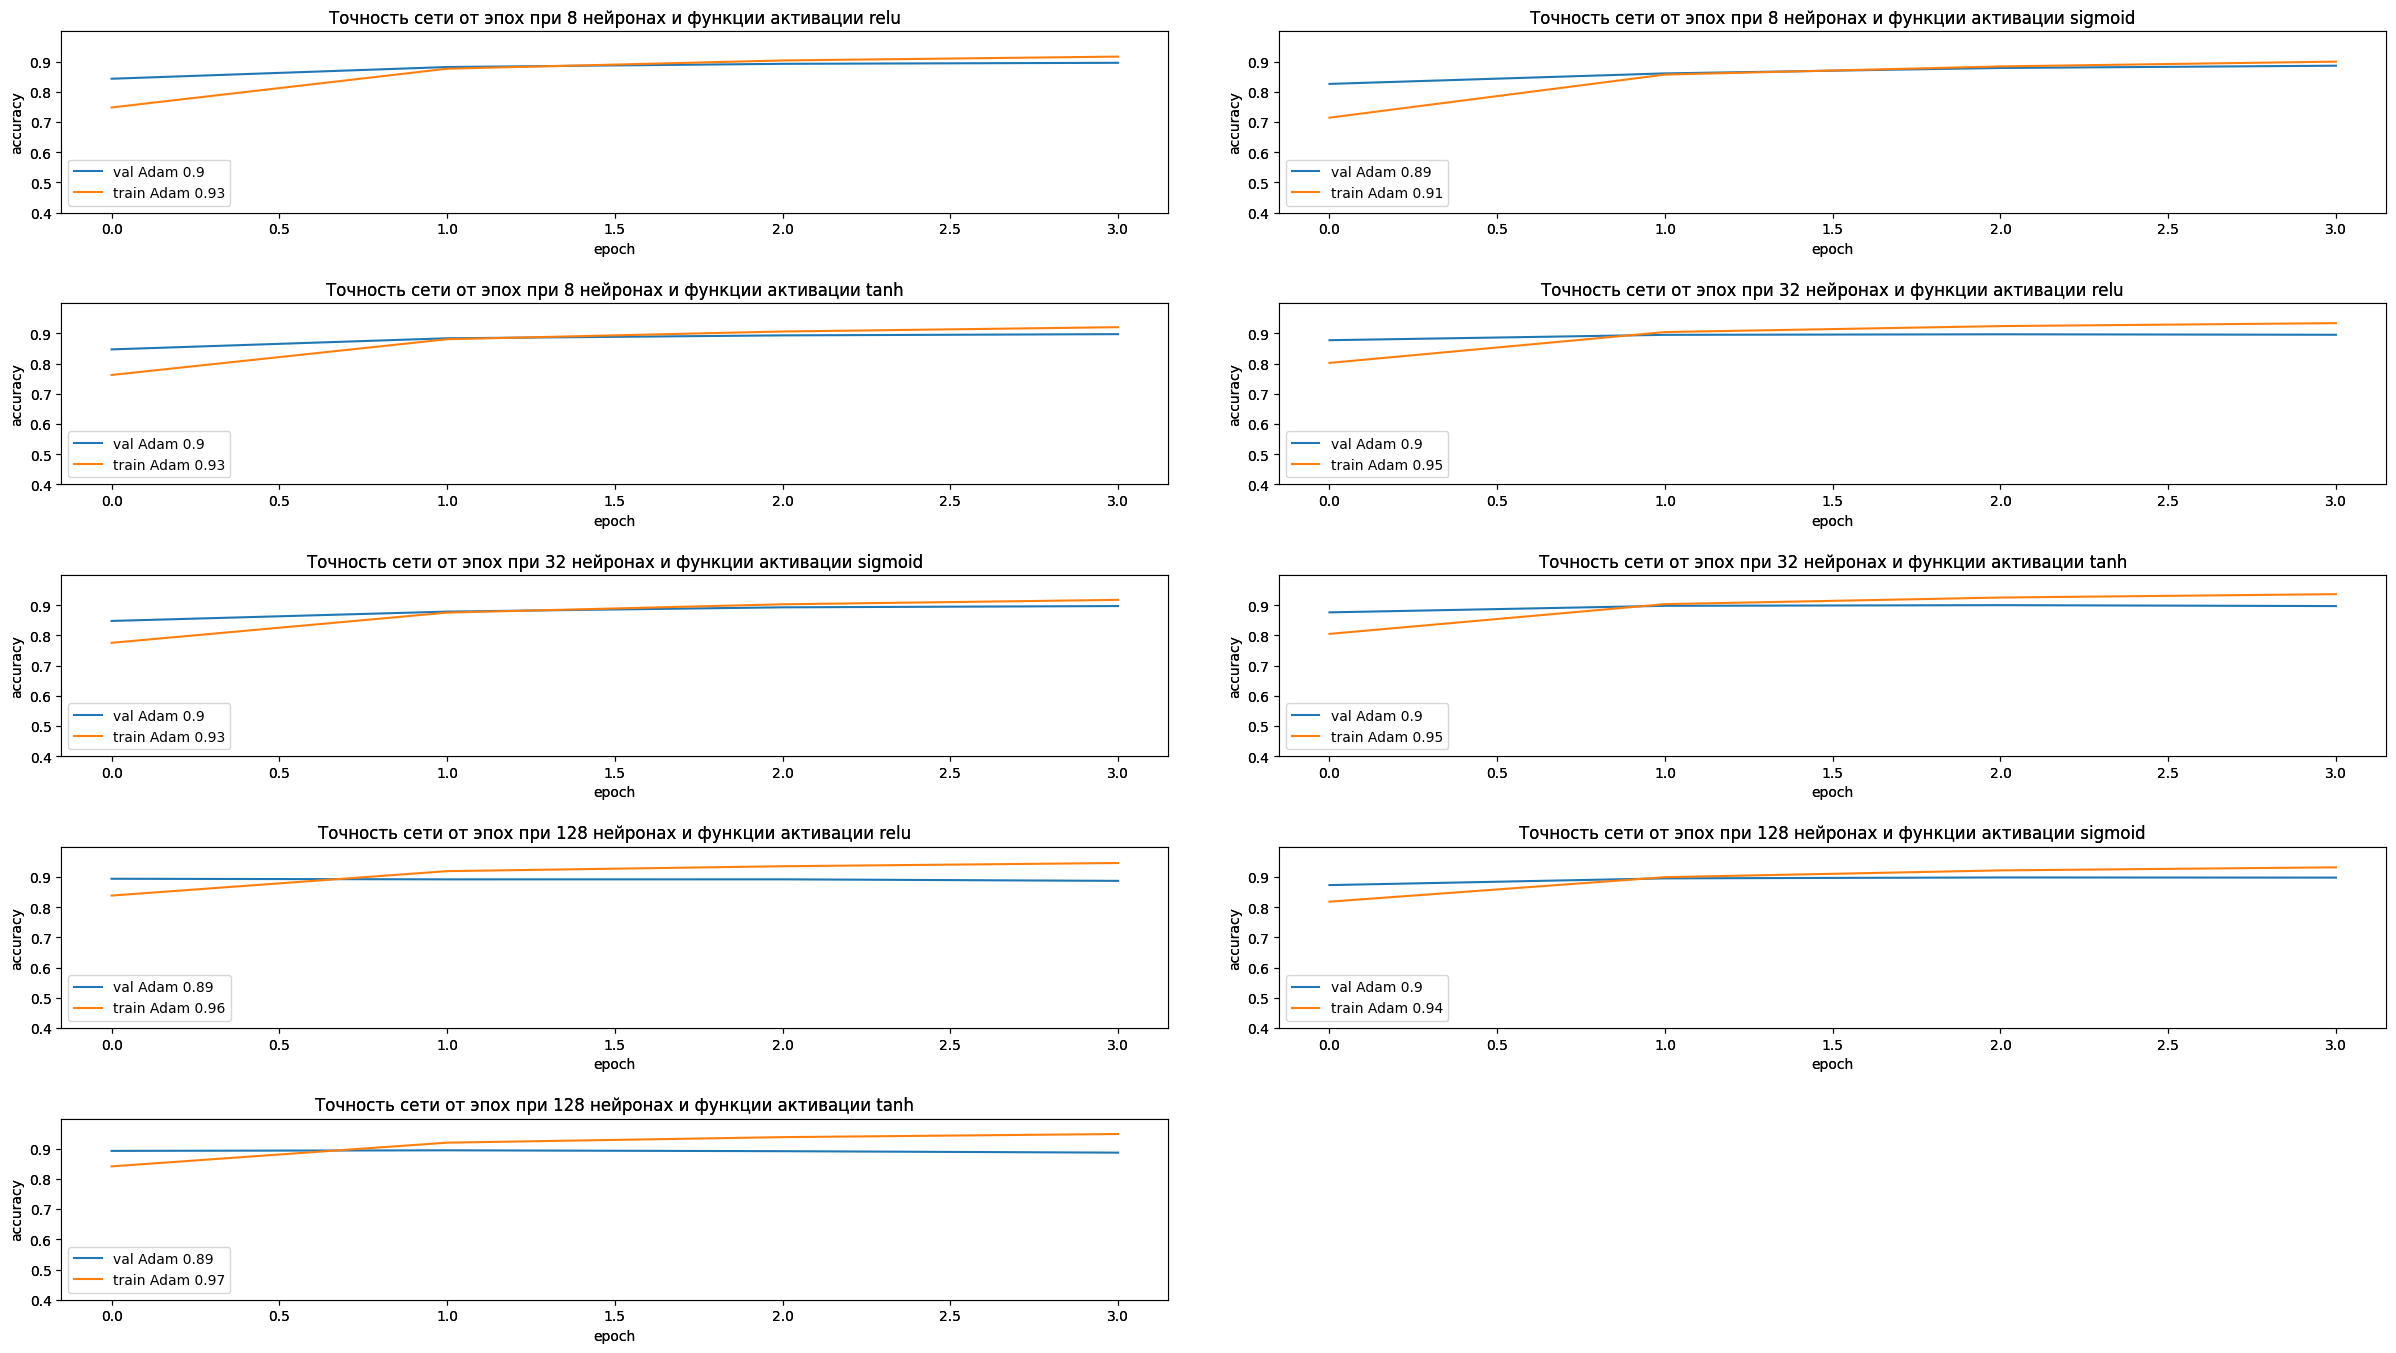

In [9]:
model_layer_3 = model_by_parameters(3, parameters)
logs = logs.append(model_layer_3)

### Модель с пятью слоями


Параметры текущей нейронной сети: количество слоёв - 5, нейронов - 8, функция активации - relu, оптимизатор - RMSprop
1250/1250 - 3s - loss: 0.2729 - accuracy: 0.8953 - 3s/epoch - 2ms/step
313/313 - 1s - loss: 0.2983 - accuracy: 0.8801 - 675ms/epoch - 2ms/step

Параметры текущей нейронной сети: количество слоёв - 5, нейронов - 8, функция активации - relu, оптимизатор - Adam
1250/1250 - 3s - loss: 0.1712 - accuracy: 0.9370 - 3s/epoch - 2ms/step
313/313 - 1s - loss: 0.2713 - accuracy: 0.8976 - 619ms/epoch - 2ms/step

Параметры текущей нейронной сети: количество слоёв - 5, нейронов - 8, функция активации - sigmoid, оптимизатор - RMSprop
1250/1250 - 2s - loss: 0.6931 - accuracy: 0.5013 - 2s/epoch - 2ms/step
313/313 - 1s - loss: 0.6932 - accuracy: 0.4947 - 592ms/epoch - 2ms/step

Параметры текущей нейронной сети: количество слоёв - 5, нейронов - 8, функция активации - sigmoid, оптимизатор - Adam
1250/1250 - 2s - loss: 0.5131 - accuracy: 0.9035 - 2s/epoch - 2ms/step
313/313 - 1s - loss: 0.5

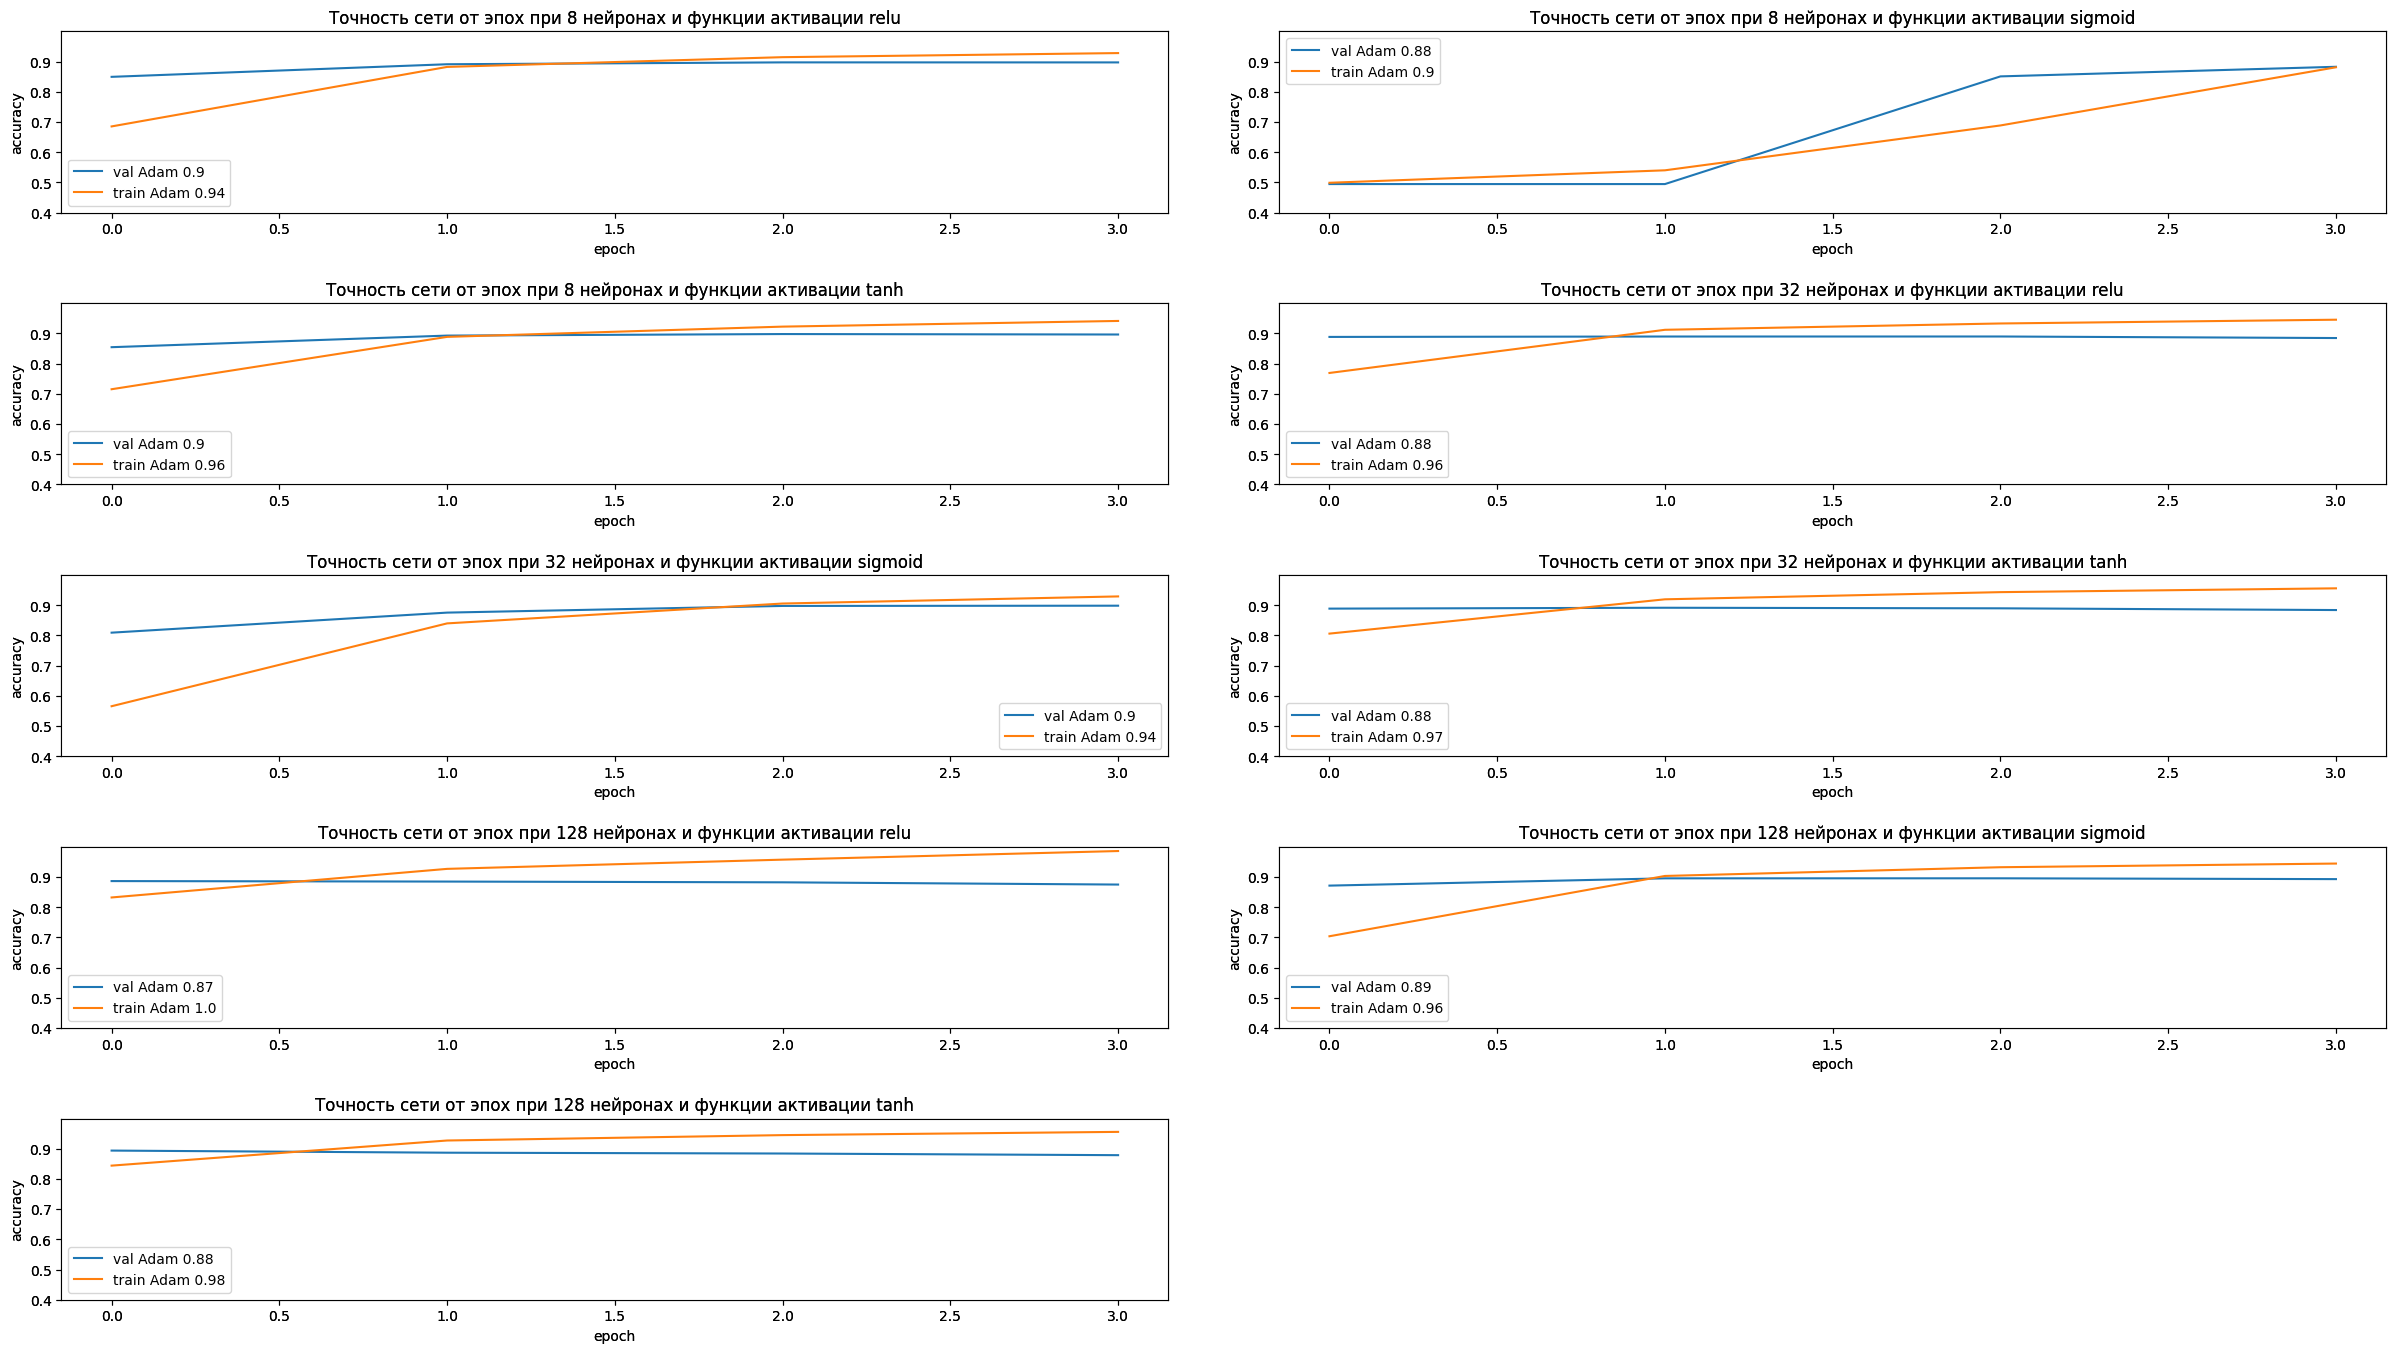

In [10]:
model_layer_5 = model_by_parameters(5, parameters)
logs = logs.append(model_layer_5)

### Модель с десятью слоями


Параметры текущей нейронной сети: количество слоёв - 10, нейронов - 8, функция активации - relu, оптимизатор - RMSprop
1250/1250 - 2s - loss: 0.6931 - accuracy: 0.5013 - 2s/epoch - 2ms/step
313/313 - 1s - loss: 0.6932 - accuracy: 0.4947 - 554ms/epoch - 2ms/step

Параметры текущей нейронной сети: количество слоёв - 10, нейронов - 8, функция активации - relu, оптимизатор - Adam
1250/1250 - 2s - loss: 0.6931 - accuracy: 0.5013 - 2s/epoch - 2ms/step
313/313 - 1s - loss: 0.6932 - accuracy: 0.4947 - 562ms/epoch - 2ms/step

Параметры текущей нейронной сети: количество слоёв - 10, нейронов - 8, функция активации - sigmoid, оптимизатор - RMSprop
1250/1250 - 2s - loss: 0.6931 - accuracy: 0.5013 - 2s/epoch - 2ms/step
313/313 - 1s - loss: 0.6932 - accuracy: 0.4947 - 572ms/epoch - 2ms/step

Параметры текущей нейронной сети: количество слоёв - 10, нейронов - 8, функция активации - sigmoid, оптимизатор - Adam
1250/1250 - 3s - loss: 0.6932 - accuracy: 0.5013 - 3s/epoch - 2ms/step
313/313 - 1s - loss:

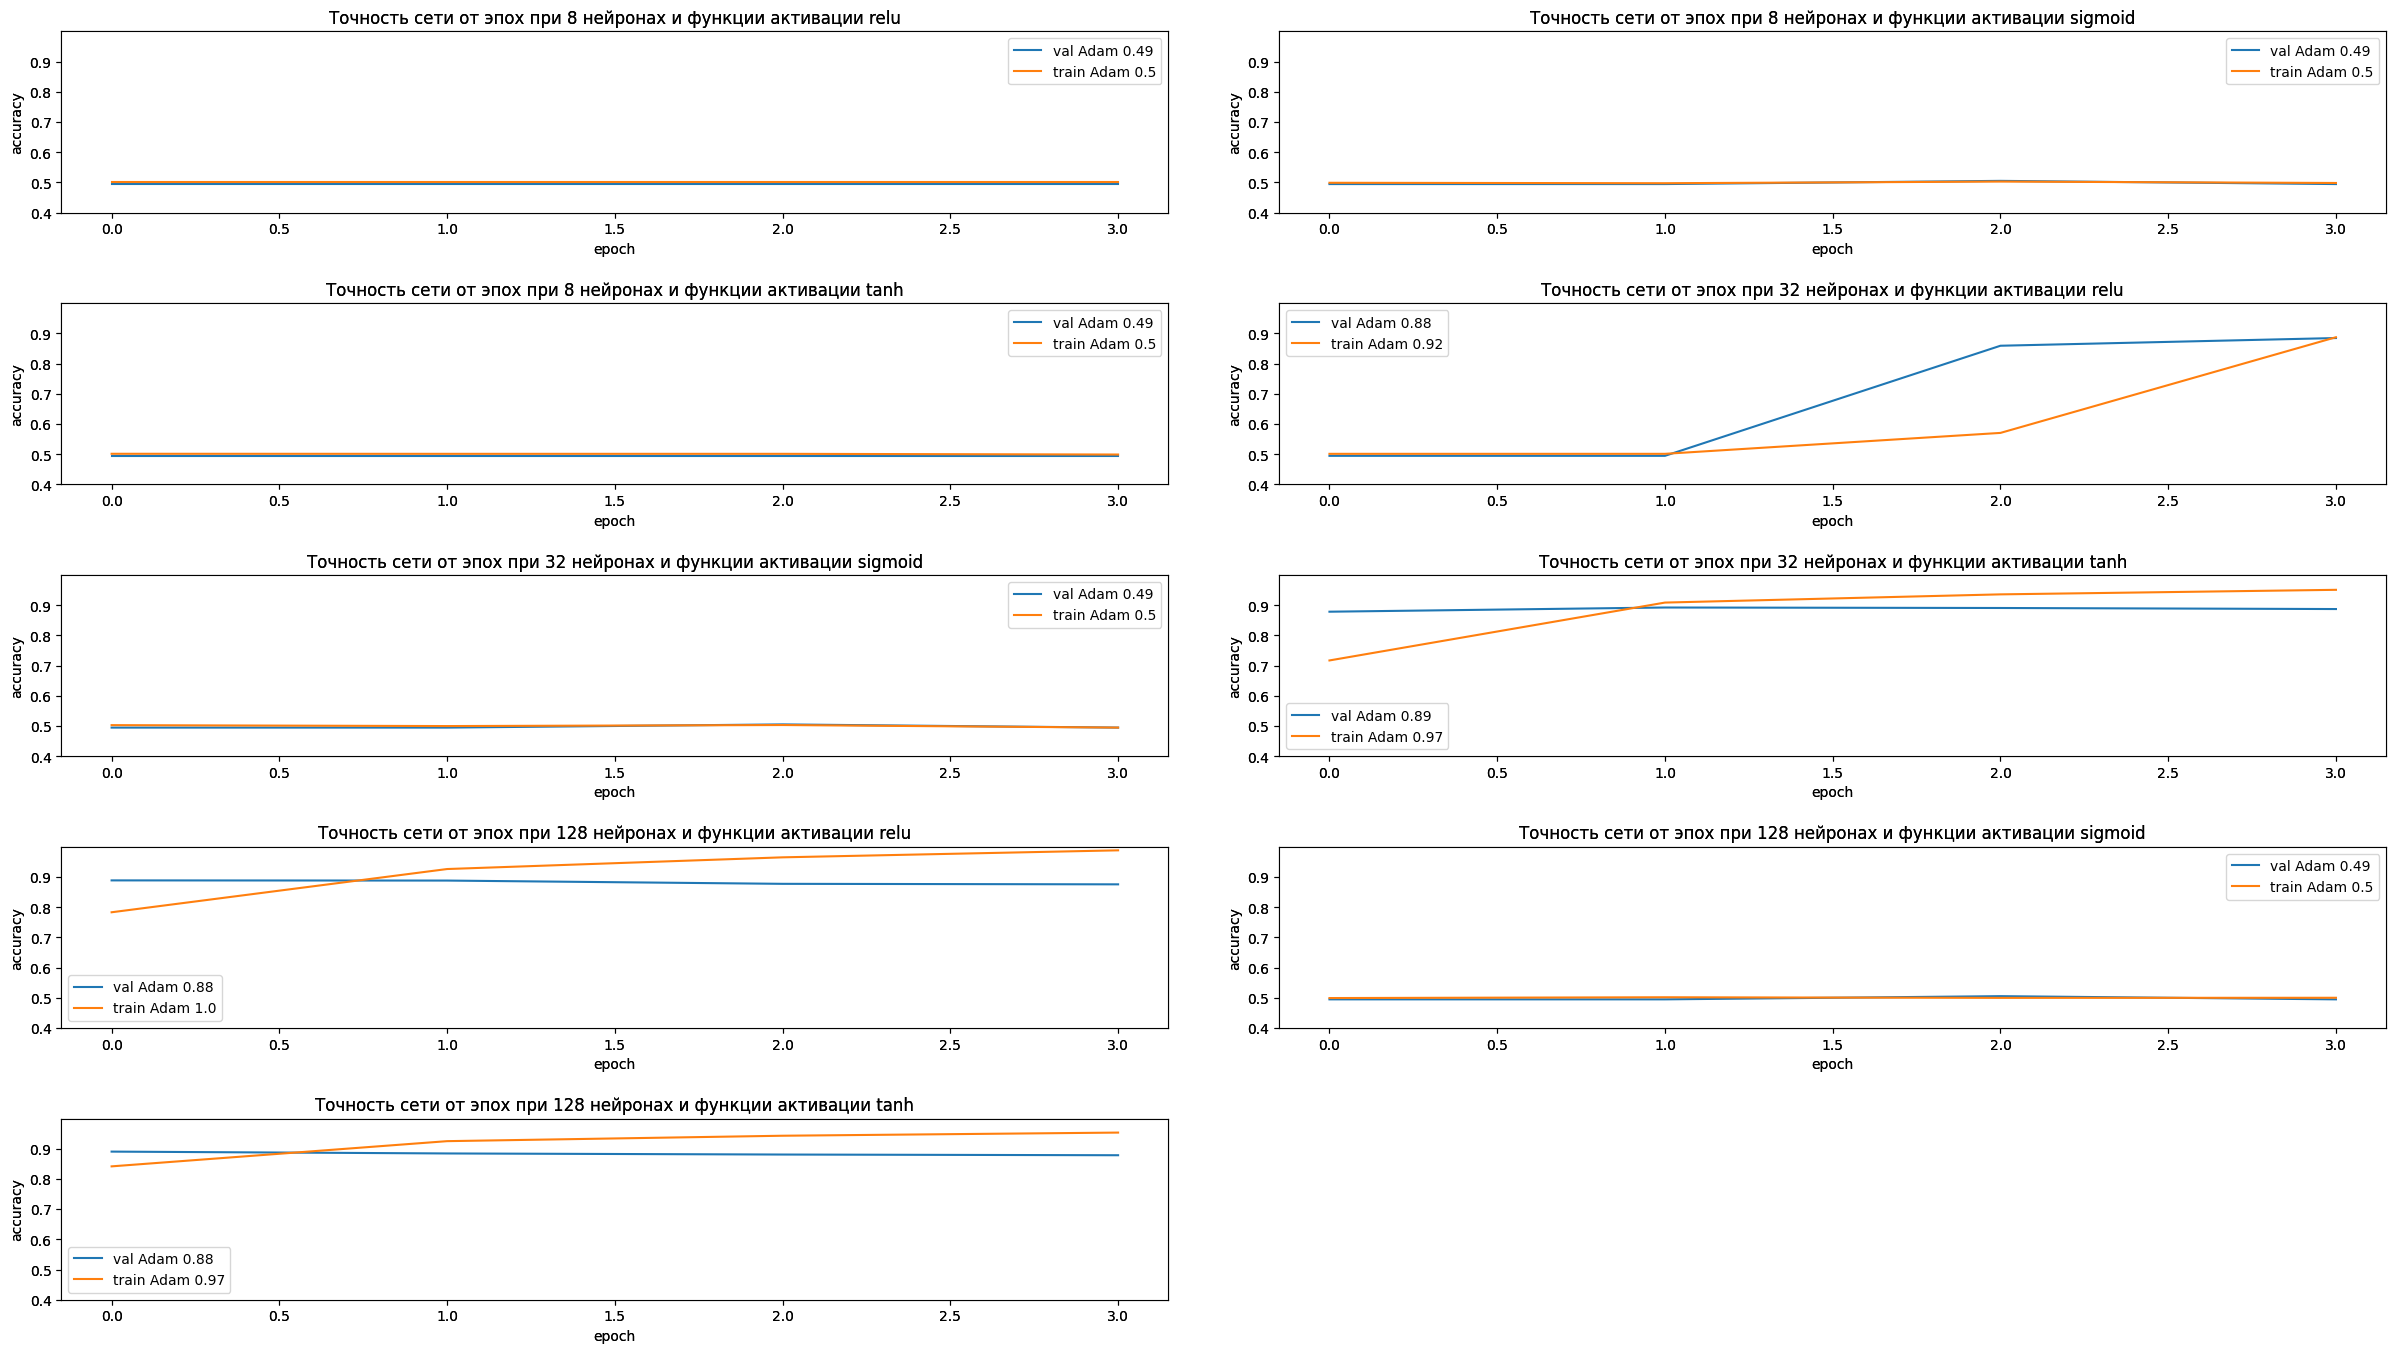

In [11]:
model_layer_10 = model_by_parameters(10, parameters)
logs = logs.append(model_layer_10)

### Сравним результаты

In [12]:
logs['overtr_diff'] = logs['test_acc'] - logs['train_acc']
logs.sort_values(by=['test_acc','overtr_diff'], ascending=[False, False])

,n_layers,n_nums,act_func,opt,train_acc,test_acc,overtr_diff
9,5,32,sigmoid,Adam,0.944900,0.8984,-0.046500
15,3,128,sigmoid,Adam,0.943900,0.8979,-0.046000
5,3,8,tanh,Adam,0.932475,0.8977,-0.034775
1,5,8,relu,Adam,0.936950,0.8976,-0.039350
9,3,32,sigmoid,Adam,0.926975,0.8972,-0.029775
11,3,32,tanh,Adam,0.950275,0.8971,-0.053175
5,5,8,tanh,Adam,0.957850,0.8965,-0.061350
1,3,8,relu,Adam,0.926125,0.8963,-0.029825
7,3,32,relu,Adam,0.945275,0.8956,-0.049675
12,3,128,relu,RMSprop,0.928200,0.8954,-0.032800


### Выводы
1. Лучшее качество получилось с количеством слоёв - 5, нейронов - 32. Модели с 10, в основном, показали себя хуже остальных
2. Наименьшая ошибка получилась с оптимизатором Adam
3. Лучше всего себя показала функция активации sigmoid
4. Получили сравнительно небольшую ошибку, но довольно большое переобучение

In [13]:
# Создадим эту модель
inputs = Input(shape=(num_words,))

x = Flatten()(inputs)
for i in range(3):
    x = Dense(32, activation='sigmoid', kernel_initializer=initializer)(x)
outputs = Dense(1, activation='sigmoid', kernel_initializer=initializer)(x)

model = Model(inputs, outputs)

model.compile(optimizer='Adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(X_test, y_test), 
                    verbose=1)

train_loss, train_m = model.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model.evaluate(X_test, y_test, verbose=2)

Model: "model_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_55 (InputLayer)       [(None, 10000)]           0         
                                                                 
 flatten_54 (Flatten)        (None, 10000)             0         
                                                                 
 dense_270 (Dense)           (None, 32)                320032    
                                                                 
 dense_271 (Dense)           (None, 32)                1056      
                                                                 
 dense_272 (Dense)           (None, 32)                1056      
                                                                 
 dense_273 (Dense)           (None, 1)                 33        
                                                                 
Total params: 322,177
Trainable params: 322,177
Non-traina

In [14]:
# Получим предсказания модели для обех выборок
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [15]:
# Округлим до ближайшего целого числа
y_train_pred = np.rint(y_train_pred)
y_test_pred = np.rint(y_test_pred)

In [16]:
# Создадим матрицы путаницы
conf_train = conf_m(y_train, y_train_pred)
conf_test = conf_m(y_test, y_test_pred)

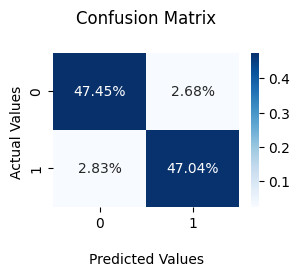

In [19]:
plt.figure(figsize = (3, 2))
ax = sns.heatmap(conf_train/np.sum(conf_train), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
plt.show()

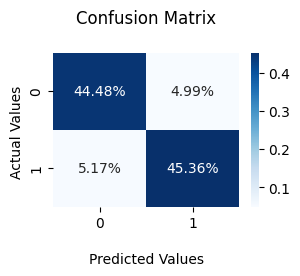

In [20]:
plt.figure(figsize = (3, 2))
ax = sns.heatmap(conf_test/np.sum(conf_test), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
plt.show()

### Общий вывод
**Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?**<br>
В итоге добились сравнительно неплохого качества модели. <br>
Для того чтобы обучить большее количество слоёв нужно больше эпох. Но надо не забывать про переобучение.<br>
Оптимизаторы и функции активации надо подбирать исходя из количества слоев и нейронов, так как разные значения показывают разное качество и нет ярко-выраженной зависимости. <br>
Для задач классификации больше подходят функции активации sigmoid.<br>
